In [1]:
from matplotlib import pyplot as plt
import numpy as np
import json
import os
import re

In [2]:
RESULTS_DIR = 'results'
TEST_TYPE = 'tmax'

In [3]:
fnames = [f for f in os.listdir(RESULTS_DIR) if TEST_TYPE in f]
fpaths = [os.path.join(RESULTS_DIR, f) for f in fnames]
effects = [re.findall('(\w+)_\w+.json', f)[0] for f in fnames]

In [4]:
def read_json(fp):
    with open(fp, 'r') as f:
        d = json.load(f)
    return d

res = [read_json(f) for f in fpaths]

In [5]:
def get_expected_n(beta, fixed_n = 30, n_looks = 2, spending_type = 'asP'):
    '''
    Arguments
    ---------
    beta : float
        The Type II error of the fixed sample design
        that's power you're trying to match.
    n_looks : int
        The number of (evenly spaced) looks at the data.
    spending_type : 'asP' | 'asOF', default: 'asP'
        'asP' uses a Pocock spending function (default)
        'asOF' uses an OBrien Fleming spending function


    Notes
    -------
    Requires R to be installed in your environment.

    '''
    from rpy2 import robjects
    fv = robjects.r(
        '''
        if (!('rpact' %%in%% installed.packages())) {
            install.packages(
                'rpact', type = 'source',
                repos = 'http://cran.us.r-project.org'
            )
        }
        design <- rpact::getDesignGroupSequential(
            kMax = %d, beta = %f, typeOfDesign = '%s'
        )
        chars <- rpact::getDesignCharacteristics(design)
        chars$averageSampleNumber1
        '''%(n_looks, beta, spending_type)
    )
    return fixed_n*fv[0]

In [6]:
power_fixed = [r['power_fixed'] for r in res]
power_sequential = [r['cumulative_power'][-1] for r in res]
n_exp = [r['n_expected'] for r in res]

pows = np.linspace(.1, .99)
betas = 1 - pows
n_exps_pred = [get_expected_n(beta) for beta in betas]

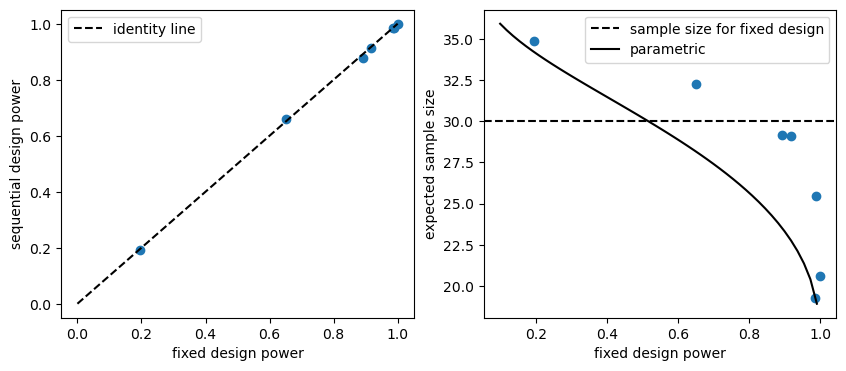

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].scatter(power_fixed, power_sequential)
axs[0].plot([0, 1], [0, 1], '--', color = 'black', label = 'identity line')
axs[0].set_xlabel('fixed design power')
axs[0].set_ylabel('sequential design power')
axs[0].legend()

axs[1].scatter(power_fixed, n_exp)
axs[1].axhline(
    res[0]['n_fixed'], 
    linestyle = '--', 
    color = 'black',
    label = 'sample size for fixed design'
)
axs[1].plot(pows, n_exps_pred, color = 'black', label = 'parametric')
axs[1].set_xlabel('fixed design power')
axs[1].set_ylabel('expected sample size')
axs[1].legend()

plt.show()